# Importing Packages

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error

# XGBoost
import xgboost as xgb

# Bayes Optimization
import optuna
from functools import partial

# Saving Models
import joblib

# Helper Functions

In [2]:
def optimize(trial, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    """
    Function used to produce optimized (Bayesian Optimization) Random Forests regressor
    
    INPUTS:
        :trial: One Optimization trial.
        :X_train (np.ndarray): Training data
        :y_train (np.ndarray): Training labels
        :X_test (np.ndarray): Testing data
        :y_test (np.ndarray): Testing labels
    """
    # Define Parameter Space
    criterion = trial.suggest_categorical("criterion", ["absolute_error", "squared_error", "poisson"])
    n_estimators = trial.suggest_int("n_estimators", 100, 1500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    max_features = trial.suggest_uniform("max_features", 0.01, 1.0)
    max_samples = trial.suggest_uniform("max_samples", 0.01, 1.0)
    learning_rate = trial.suggest_uniform("learning_rate", 0.001, 0.01)
    gamma = trial.suggest_uniform("gamma", 0.001, 0.02)

    # Define Model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=criterion,
        max_samples=max_samples,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=42, 
        objective="reg:squarederror"
    )
    
    # Fit model
    model.fit(X_train, y_train)
    # Predictions and MSE
    preds = model.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=preds)

    # Return MSE
    return mse

In [6]:
def fit_xgb_model(df: pd.DataFrame, company_name: str):
    """
    Fitting an Optimized Random Forests Model for each Company
    
    INPUTS:
        :df (pd.DataFrame): Input dataframe
        :company_name (str): Company name
    """
    # Train test split
    train = df.loc[:"2021-10-29", :]
    test = df.loc["2021-10-29":, :]
    # Splitting into targets and features
    X_train, y_train = train.drop(["Adj_Close"], axis=1).to_numpy(), train["Adj_Close"].to_numpy()
    X_test, y_test = test.drop(["Adj_Close"], axis=1).to_numpy(), test["Adj_Close"].to_numpy()
    
    # Bayesian Optimization using Optuna
    optimization_function = partial(optimize, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study = optuna.create_study(direction="minimize")
    study.optimize(optimization_function, n_trials=15)
    
    # Fitting the best model
    model = xgb.XGBRegressor(**study.best_params, random_state=42, objective="reg:squarederror")
    model.fit(X_train, y_train)

    # Train and Test Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Train and Test performance (MSE and RMSE)
    train_mse = mean_squared_error(y_true=y_train, y_pred=train_preds)
    test_mse = mean_squared_error(y_true=y_train, y_pred=train_preds)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    print(f"Training RMSE: {round(train_rmse, 4)}")
    print(f"Testing RMSE: {round(test_rmse, 4)}")
    print("-"*30, end="\n\n")


    # Plotting train and test predictions vs actual values
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(y_train, label="Train values")
    ax[0].plot(train_preds, label="Train predictions")
    ax[0].set_xlabel("Time", size=12)
    ax[0].set_ylabel("Stock Price", size=12)
    ax[0].set_ylim([y_train.min()-10, y_train.max()+10])
    ax[0].set_title(f"{company_name}: Train values vs predictions", size=15)
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(y_test, label="Test values")
    ax[1].plot(test_preds, label="Test predictions")
    ax[1].set_xlabel("Time", size=12)
    ax[1].set_ylabel("Stock Price", size=12)
    ax[1].set_ylim([y_train.min()-10, y_test.max()+10])
    ax[1].set_title(f"{company_name}: Test values vs predictions", size=15)
    ax[1].grid()
    ax[1].legend()

    plt.show()
    
    # Returning Model
    return model

# Fitting models for each company

## Facebook

Reading dataset, and adding past 10 days observations.

In [7]:
df = pd.read_csv("/content/fb_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-08 04:00:24,929] A new study created in memory with name: no-name-fc587993-d78f-4b9c-ac8f-7dd8c54a0c26
[I 2021-12-08 04:00:25,477] Trial 0 finished with value: 46965.59966645771 and parameters: {'criterion': 'poisson', 'n_estimators': 185, 'max_depth': 5, 'max_features': 0.5407076459706737, 'max_samples': 0.6420218633222263, 'learning_rate': 0.002353212067329244, 'gamma': 0.01708639559152916}. Best is trial 0 with value: 46965.59966645771.
[I 2021-12-08 04:00:26,321] Trial 1 finished with value: 2124.5801036694847 and parameters: {'criterion': 'absolute_error', 'n_estimators': 279, 'max_depth': 9, 'max_features': 0.3221730353661813, 'max_samples': 0.3971683665325378, 'learning_rate': 0.007210175398185685, 'gamma': 0.0039011955544398006}. Best is trial 1 with value: 2124.5801036694847.
[I 2021-12-08 04:00:30,809] Trial 2 finished with value: 174.4106054758145 and parameters: {'criterion': 'absolute_error', 'n_estimators': 1331, 'max_depth': 7, 'max_features': 0.71868114521627

Training RMSE: 3.0734
Testing RMSE: 3.0734
------------------------------



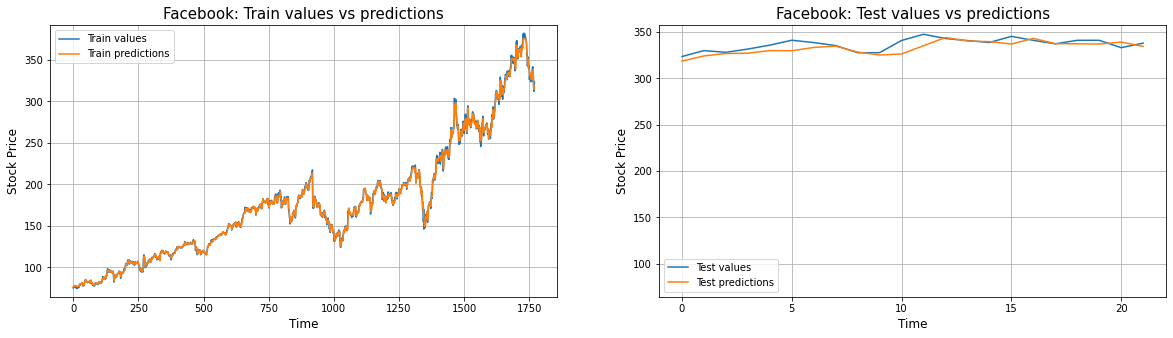

In [8]:
fb_model = fit_xgb_model(df = df, company_name = "Facebook")

## Apple

Reading dataset, and adding past 10 days observations.

In [9]:
df = pd.read_csv("/content/aapl_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-08 04:01:03,943] A new study created in memory with name: no-name-f4e04ae1-1cbb-4af1-807d-0e2d0c01d073
[I 2021-12-08 04:01:06,948] Trial 0 finished with value: 55.308562519494444 and parameters: {'criterion': 'squared_error', 'n_estimators': 1180, 'max_depth': 4, 'max_features': 0.42996143951469334, 'max_samples': 0.8019782659760294, 'learning_rate': 0.0047865276466711355, 'gamma': 0.016048698421948598}. Best is trial 0 with value: 55.308562519494444.
[I 2021-12-08 04:01:11,450] Trial 1 finished with value: 67.52538552050564 and parameters: {'criterion': 'poisson', 'n_estimators': 969, 'max_depth': 10, 'max_features': 0.8132594426759326, 'max_samples': 0.5312214906897379, 'learning_rate': 0.005402265205756875, 'gamma': 0.009309009948798581}. Best is trial 0 with value: 55.308562519494444.
[I 2021-12-08 04:01:14,111] Trial 2 finished with value: 50.79995958909223 and parameters: {'criterion': 'poisson', 'n_estimators': 883, 'max_depth': 5, 'max_features': 0.5368628243201273, 

Training RMSE: 2.8223
Testing RMSE: 2.8223
------------------------------



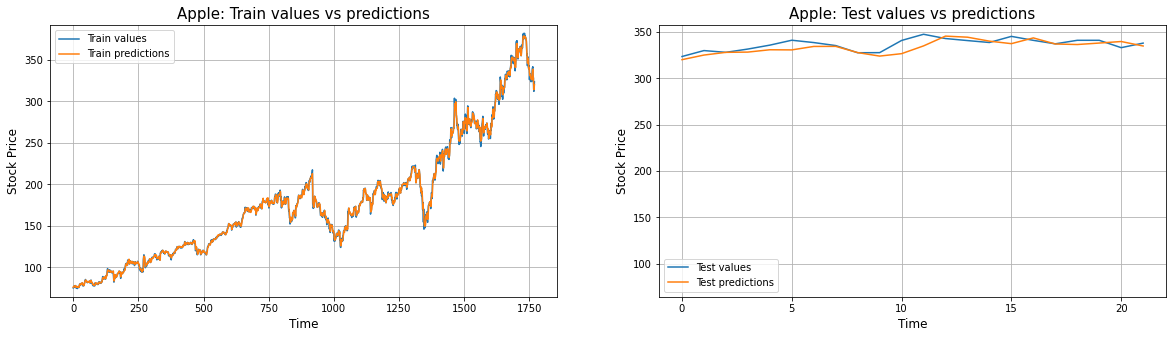

In [10]:
aapl_model = fit_xgb_model(df = df, company_name = "Apple")

## Amazon

Reading dataset, and adding past 10 days observations.

In [11]:
df = pd.read_csv("/content/amzn_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-08 04:02:18,943] A new study created in memory with name: no-name-af3e6063-c27d-4125-830f-79a28b6145fd
[I 2021-12-08 04:02:19,953] Trial 0 finished with value: 404.8476168708876 and parameters: {'criterion': 'absolute_error', 'n_estimators': 320, 'max_depth': 10, 'max_features': 0.026280685065442046, 'max_samples': 0.6947391200033943, 'learning_rate': 0.009056841030163586, 'gamma': 0.0059302564366070214}. Best is trial 0 with value: 404.8476168708876.
[I 2021-12-08 04:02:21,759] Trial 1 finished with value: 2008.3507310771383 and parameters: {'criterion': 'absolute_error', 'n_estimators': 730, 'max_depth': 4, 'max_features': 0.3489632790780764, 'max_samples': 0.9271249959865893, 'learning_rate': 0.0027860162124964515, 'gamma': 0.009024455494268419}. Best is trial 0 with value: 404.8476168708876.
[I 2021-12-08 04:02:22,853] Trial 2 finished with value: 319.98070094031704 and parameters: {'criterion': 'absolute_error', 'n_estimators': 349, 'max_depth': 13, 'max_features': 0.69

Training RMSE: 0.6113
Testing RMSE: 0.6113
------------------------------



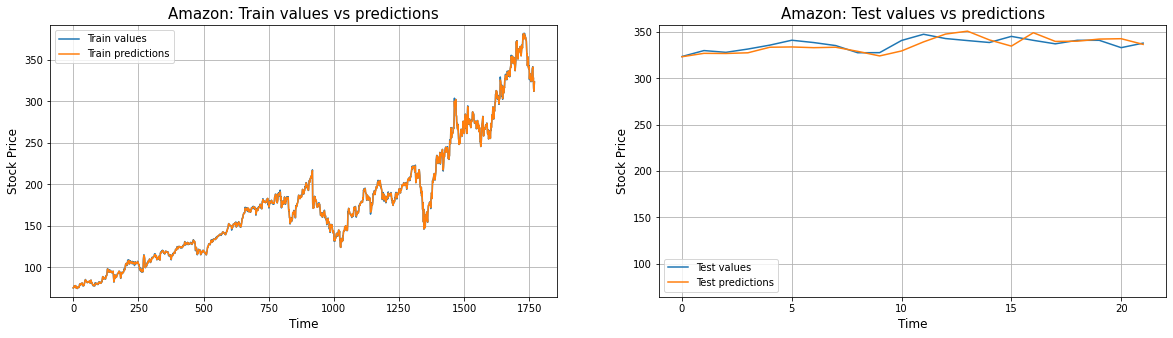

In [12]:
amzn_model = fit_xgb_model(df = df, company_name = "Amazon")

## Netflix

Reading dataset, and adding past 10 days observations.

In [13]:
df = pd.read_csv("/content/nflx_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-08 04:03:46,299] A new study created in memory with name: no-name-3361085b-4b1b-410e-87f2-35be10e7888e
[I 2021-12-08 04:03:48,857] Trial 0 finished with value: 554.0868596904911 and parameters: {'criterion': 'poisson', 'n_estimators': 840, 'max_depth': 15, 'max_features': 0.625921175541322, 'max_samples': 0.8521101768863246, 'learning_rate': 0.0032441928981982947, 'gamma': 0.007177444916407964}. Best is trial 0 with value: 554.0868596904911.
[I 2021-12-08 04:03:49,415] Trial 1 finished with value: 4711.329140952492 and parameters: {'criterion': 'absolute_error', 'n_estimators': 184, 'max_depth': 9, 'max_features': 0.5288702208773084, 'max_samples': 0.21349782976164758, 'learning_rate': 0.008622573779286942, 'gamma': 0.012810363736396272}. Best is trial 0 with value: 554.0868596904911.
[I 2021-12-08 04:03:51,609] Trial 2 finished with value: 63.68848471364684 and parameters: {'criterion': 'absolute_error', 'n_estimators': 534, 'max_depth': 9, 'max_features': 0.016000478815635

Training RMSE: 3.0314
Testing RMSE: 3.0314
------------------------------



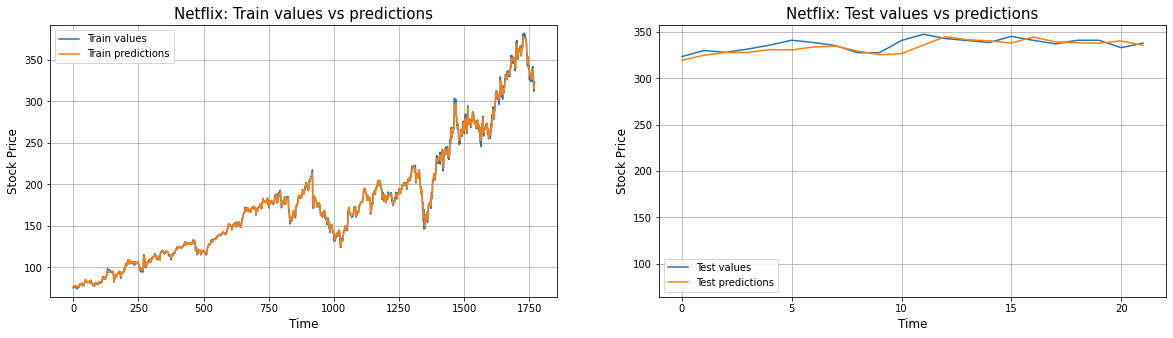

In [14]:
nflx_model = fit_xgb_model(df = df, company_name = "Netflix")

## Google

Reading dataset, and adding past 10 days observations.

In [15]:
df = pd.read_csv("/content/goog_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-08 04:04:32,752] A new study created in memory with name: no-name-82239045-f734-41b2-a5f4-3ab0f69440ad
[I 2021-12-08 04:04:38,458] Trial 0 finished with value: 41.49546618310904 and parameters: {'criterion': 'poisson', 'n_estimators': 856, 'max_depth': 13, 'max_features': 0.6631585755016945, 'max_samples': 0.07867096918395544, 'learning_rate': 0.008557190363904057, 'gamma': 0.007941196952062888}. Best is trial 0 with value: 41.49546618310904.
[I 2021-12-08 04:04:39,352] Trial 1 finished with value: 490.16283638216555 and parameters: {'criterion': 'squared_error', 'n_estimators': 294, 'max_depth': 15, 'max_features': 0.2173842148061857, 'max_samples': 0.16924078144063417, 'learning_rate': 0.009483348217777972, 'gamma': 0.009109701685638537}. Best is trial 0 with value: 41.49546618310904.
[I 2021-12-08 04:04:46,869] Trial 2 finished with value: 38.782094572924755 and parameters: {'criterion': 'absolute_error', 'n_estimators': 1460, 'max_depth': 9, 'max_features': 0.40744165981

Training RMSE: 2.5205
Testing RMSE: 2.5205
------------------------------



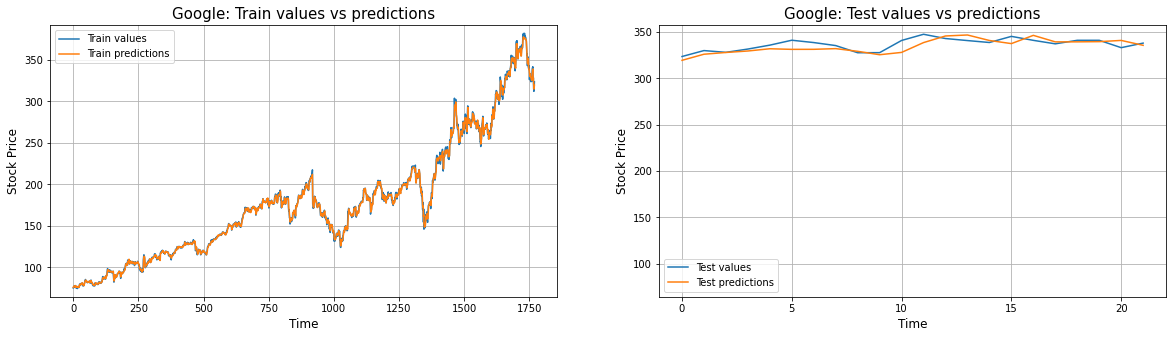

In [16]:
goog_model = fit_xgb_model(df = df, company_name = "Google")

# Saving Models

In [17]:
joblib.dump(fb_model, "xgb_fb.joblib")
joblib.dump(aapl_model, "xgb_aapl.joblib")
joblib.dump(amzn_model, "xgb_amzn.joblib")
joblib.dump(nflx_model, "xgb_nflx.joblib")
joblib.dump(goog_model, "xgb_goog.joblib")

['xgb_goog.joblib']